### In this notebook one fit logistic regression built on Pytorch on the raw event stream and on HOTS outputs

In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../HOTS'

/Users/laurentperrinet/quantic/science/HomeHots/HOTS_clone_laurent/HOTS


In [2]:
from Tools import tic,toc, get_loader, fit_data, predict_data, classification_results
record_path = '../Records/EXP_03_NMNIST/models/'

# Network parameters

In [3]:
sigma = None
pooling = False
homeinv = False
jitonic = [None,None] #[temporal, spatial]
jitter = False
tau = 5
nblay = 3
nbclust = 4
filt = 2
timestr = '2021-02-16'

In [4]:
nb_test = 10000
nb_train = 60000
ds = 1200
ds = 120
nb_test = nb_test//ds
nb_train = nb_train//ds
print(f'training set size: {nb_train} - testing set: {nb_test}')

training set size: 500 - testing set: 83


# LR Parameters

In [5]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
#num_epochs = 2 ** 9 + 1
num_epochs

33

# Loading raw input as a dataset

In [6]:
name = 'raw'
learn_set, nb_pola, name_net = get_loader(name, record_path, nb_train, True, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)

# Fitting LR on the raw inputs

In [7]:
tic()
model, loss = fit_data(name_net, learn_set, nb_train,nb_pola,learning_rate,num_epochs,betas,verbose=True)
toc()

device -> cpu
Iteration: 0 - Loss: 0.33744
Iteration: 1 - Loss: 0.24458
Iteration: 2 - Loss: 0.27945
Iteration: 3 - Loss: 0.27051
Iteration: 4 - Loss: 0.23565
Iteration: 5 - Loss: 0.25829
Iteration: 6 - Loss: 0.25266
Iteration: 7 - Loss: 0.26049
Iteration: 8 - Loss: 0.33353
Iteration: 9 - Loss: 0.25712
Iteration: 10 - Loss: 0.23366
Iteration: 11 - Loss: 0.26261
Iteration: 12 - Loss: 0.27324
Iteration: 13 - Loss: 0.25135
Iteration: 14 - Loss: 0.25992
Iteration: 15 - Loss: 0.22432
Iteration: 16 - Loss: 0.28176
Iteration: 17 - Loss: 0.33863
Iteration: 18 - Loss: 0.26487
Iteration: 19 - Loss: 0.25824
Iteration: 20 - Loss: 0.23031
Iteration: 21 - Loss: 0.26215
Iteration: 22 - Loss: 0.25325
Iteration: 23 - Loss: 0.28515
Iteration: 24 - Loss: 0.22937
Iteration: 25 - Loss: 0.22946
Iteration: 26 - Loss: 0.23550
Iteration: 27 - Loss: 0.25197
Iteration: 28 - Loss: 0.22996
Iteration: 29 - Loss: 0.21081
Iteration: 30 - Loss: 0.26920
Iteration: 31 - Loss: 0.22428
Iteration: 32 - Loss: 0.20644
Done i

# Testing on the raw inputs


In [8]:
test_set, nb_pola, name_net = get_loader(name, record_path, nb_test, False, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)

In [9]:
pred_target, true_target = predict_data(test_set, model, nb_test)

np.mean(accuracy)=0.844


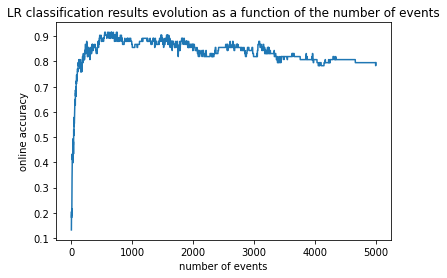

In [10]:
mean_acc, online_acc = classification_results(pred_target, true_target, nb_test, verbose= True)

# LR on the output of HOTS

In [11]:
name = 'homhots'
learn_set, nb_pola, name_net = get_loader(name, record_path, nb_train, True, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)

tic()
model, loss = fit_data(name_net, learn_set, nb_train, nb_pola, learning_rate, num_epochs, betas, verbose=True)
toc()

../Records/EXP_03_NMNIST/train/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_500_[None, None].pkl
no jitter


100%|██████████| 500/500 [17:57<00:00,  2.16s/it]


device -> cpu
Iteration: 0 - Loss: 0.15923
Iteration: 1 - Loss: 0.07293
Iteration: 2 - Loss: 0.03764
Iteration: 3 - Loss: 0.02331
Iteration: 4 - Loss: 0.01387
Iteration: 5 - Loss: 0.01230
Iteration: 6 - Loss: 0.00347
Iteration: 7 - Loss: 0.00244
Iteration: 8 - Loss: 0.00275
Iteration: 9 - Loss: 0.00215
Iteration: 10 - Loss: 0.00202
Iteration: 11 - Loss: 0.00194
Iteration: 12 - Loss: 0.00188
Iteration: 13 - Loss: 0.00189
Iteration: 14 - Loss: 0.00177
Iteration: 15 - Loss: 0.00173
Iteration: 16 - Loss: 0.00174
Iteration: 17 - Loss: 0.00168
Iteration: 18 - Loss: 0.00162
Iteration: 19 - Loss: 0.00160
Iteration: 20 - Loss: 0.00158
Iteration: 21 - Loss: 0.00156
Iteration: 22 - Loss: 0.00154
Iteration: 23 - Loss: 0.00144
Iteration: 24 - Loss: 0.00152
Iteration: 25 - Loss: 0.00142
Iteration: 26 - Loss: 0.00145
Iteration: 27 - Loss: 0.00139
Iteration: 28 - Loss: 0.00137
Iteration: 29 - Loss: 0.00140
Iteration: 30 - Loss: 0.00139
Iteration: 31 - Loss: 0.00135
Iteration: 32 - Loss: 0.00131
Done i

../Records/EXP_03_NMNIST/test/2021-02-16_lagorce_rdn_None_True_[0.25, 1]_[4, 8, 16]_[5000.0, 50000.0, 500000.0]_[2, 4, 8]_False_83_[None, None].pkl
no jitter


100%|██████████| 83/83 [05:38<00:00,  4.08s/it]


np.mean(accuracy)=0.789


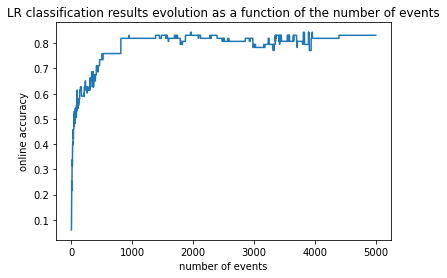

In [12]:
test_set, nb_pola, name_net = get_loader(name, record_path, nb_test, False, filt, tau, nblay, nbclust, sigma, homeinv, jitter, timestr)
pred_target, true_target = predict_data(test_set, model, nb_test)
mean_acc, online_acc = classification_results(pred_target, true_target, nb_test, verbose=True)